## Worksheet 07
***

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix
from scipy.sparse.linalg import lsqr

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


To construct X efficiently, all operations with same angle $\alpha$ can be vectorized and all image pixels can be projected on the sensor array at once.

The values, as well as their indices $i$ and $j$, to be put into the sparse matrix, are collected in three corresponding lists. This way a more efficient coordinate format (scipy.sparse.coo_matrix) can be used to assemble the matrix at the end

In [33]:
def construct_X(M, alphas, Np=None):
    """
    Construct design matrix X
    : param M: int 
        Tomogram is an array-like of shape (M, M)
    
    : param alphas: Array-like of shape (n_alphas, )
        List of measurement angles in degrees
        
    : param Np: Default=None
        Optional sensor resolution
    """
    # Define sensor size
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
        if Np % 2 == 0:
            Np += 1
    # Number of angles
    No = len(alphas)
    # Define design matrix X
    D_beta = M * M
    D_y = No * Np
    
    # Flattened output coordinates
    j = np.mgrid[0 : D_beta].astype(np.int32)
    # Coordinate matrix for the output pixels
    M2 = (M - 1) / 2  # Center matrix
    grid = np.mgrid[-M2 : M - M2, -M2 : M - M2].swapaxes(1, 2).reshape(2, D_beta)
    
    # Collect indices and corresponding values for all iterations
    i_idx = []
    j_idx = []
    weights = []
    
    for k, alpha in enumerate(alphas):
        # Covert angle and projection vector    
        alph_rad = np.radians(alpha)
        proj_vec = np.array([np.cos(alph_rad), -np.sin(alph_rad)])
        # Project coordinates
        proj = np.dot(proj_vec, grid) + Np // 2
        # Compute sensor indices and weights below the projected points
        i = np.floor(proj)
        w = (i + 1) - proj
        # Rays falling outside the sensor are not counted
        clip = np.logical_and(0 <= i, i < Np-1)
        
        i_idx.append((i + k * Np)[clip])
        j_idx.append(j[clip])
        weights.append(w[clip])
        # Compute sensor indices and weights above the projected points
        w = proj - i
        i_idx.append((i + 1 + k * Np)[clip])
        j_idx.append(j[clip])
        weights.append(w[clip])
        
    # Construct matrix X
    i = np.concatenate(i_idx).astype(np.int32)
    j = np.concatenate(j_idx).astype(np.int32)
    w = np.concatenate(weights)
    X = coo_matrix((w, (i, j)), shape=(D_y, D_beta), dtype=np.float32)
    
    return X

For the projection of the grid to the sensor array, it is only needed the projection of one axis, namely the axis projection of the $x$-axis to the sensor array:

$
\begin{bmatrix}
\cos(\alpha) & -\sin(\alpha) \\
\sin(\alpha) & \cos(\alpha) \\
\end{bmatrix} \begin{bmatrix}
x \\
y \\
\end{bmatrix}\begin{bmatrix}
\cos(\alpha) & -\sin(\alpha) \\
\sin(\alpha) & \cos(\alpha) \\
\end{bmatrix} = \begin{bmatrix}
p \\
q \\
\end{bmatrix}
$

Only $p$ axis of coordinates of new basis system are relevant for the projection to the sensor array, i.e.

$
\begin{bmatrix}
x * \cos(\alpha) - y * \sin(\alpha) \\
\end{bmatrix} = \begin{bmatrix}
p \\
\end{bmatrix} = \begin{bmatrix}
\cos(\alpha) & -\sin(\alpha) \\
\end{bmatrix} \begin{bmatrix}
x \\
y \\
\end{bmatrix}
$

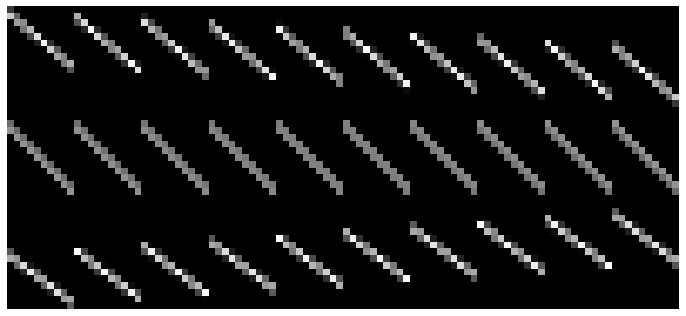

In [34]:
X = construct_X(10, [-33, 1, 42]).todense()
# np.save('X_example', X)

fig = plt.figure(figsize = (10, 4.5))
plt.imshow(X, interpolation = 'nearest')
plt.gray(); plt.axis('off'); fig.tight_layout(); plt.show()